In [1]:
import numpy as np
import random
import torch
import os
from torchvision import transforms
import scipy.io
from PIL import Image
import numpy as np
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.optim as optim
from transformers import ViTModel
from torch.optim import lr_scheduler
import torch.nn as nn
import torch.nn.functional as F

# Check if CUDA is available
if torch.cuda.is_available():
    # Get the current device
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(device)
    
    # Get the total and free memory on the current device
    total_memory = torch.cuda.get_device_properties(device).total_memory
    util_memory = torch.cuda.memory_reserved(device)
    
    # Convert bytes to megabytes
    total_memory = total_memory / (1024 ** 2)
    util_memory = util_memory / (1024 ** 2)
    
    print(f"Total GPU memory: {total_memory:.2f} MB")
    print(f"Utilized GPU memory: {util_memory:.2f} MB")
else:
    print("CUDA is not available on this machine.")

# Make it deterministic
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(42)


/home/kaibald231/work_pupil/jupyter_files/jupyter_venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda
Total GPU memory: 12002.62 MB
Utilized GPU memory: 0.00 MB


# Modele NN

In [2]:

class ImageEncoder(nn.Module):
    def __init__(self, pretrained_vit):
        super().__init__()
        self.vit = pretrained_vit

    def forward(self, x):
        outputs = self.vit(x, output_hidden_states=True, interpolate_pos_encoding=True)
        hidden_states = outputs.hidden_states
        intermediate_features = [hidden_states[i][:, 1:, :] for i in [3, 6, 9, 12]] 
        return intermediate_features 
    
    
class ConvBnReluBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_prob=0.33):
        super(ConvBnReluBlock, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1)
        #self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        #self.dropout = nn.Dropout2d(dropout_prob)

    def forward(self, x):
        x = self.conv(x)
        #x = self.bn(x)
        x = self.relu(x)
        #x = self.dropout(x)
        return x

class DeconvConvBnReluBlock(nn.Module):
    def __init__(self, in_channels, mid_channels, out_channels, dropout_prob=0.33):
        super(DeconvConvBnReluBlock, self).__init__()
        self.deconv = nn.ConvTranspose2d(in_channels, mid_channels, kernel_size=2, stride=2)
        self.conv = nn.Conv2d(mid_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        #self.dropout = nn.Dropout2d(dropout_prob)

    def forward(self, x):
        x = self.deconv(x)
        x = self.conv(x)
        x = self.bn(x)
        x = self.relu(x)
        #x = self.dropout(x)
        return x

class SaliencyDecoder(nn.Module):
    def __init__(self):
        super().__init__()

        self.deconv_z12 = nn.ConvTranspose2d(768, 384, kernel_size=2, stride=2)
        
        self.deconvconv_z9  = DeconvConvBnReluBlock(in_channels=768, mid_channels=576, out_channels=384)
        
        self.conv1_z9z12 = ConvBnReluBlock(768, out_channels=576)
        self.conv2_z9z12 = ConvBnReluBlock(in_channels=576, out_channels=384)
        self.deconv_z9z12 = nn.ConvTranspose2d(384, 192, kernel_size=2, stride=2)

        self.deconvconv1_z6  = DeconvConvBnReluBlock(in_channels=768, mid_channels=624, out_channels=480)
        self.deconvconv2_z6  = DeconvConvBnReluBlock(in_channels=480, mid_channels=336, out_channels=192)

        self.conv1_z6z12z9 = ConvBnReluBlock(in_channels=384, out_channels=288)
        self.conv2_z6z12z9 = ConvBnReluBlock(in_channels=288, out_channels=192)
        self.deconv_z6z12z9 = nn.ConvTranspose2d(192, 96, kernel_size=2, stride=2)

        self.deconvconv1_z3  = DeconvConvBnReluBlock(in_channels=768, mid_channels=672, out_channels=576)
        self.deconvconv2_z3  = DeconvConvBnReluBlock(in_channels=576, mid_channels = 432, out_channels=288)
        self.deconvconv3_z3  = DeconvConvBnReluBlock(in_channels=288, mid_channels=192, out_channels=96)

        self.conv1_z3z6z12z9 = ConvBnReluBlock(in_channels=192, out_channels=144)
        self.conv2_z3z6z12z9 = ConvBnReluBlock(in_channels=144, out_channels=96)
        self.deconv_z3z6z12z9 = nn.ConvTranspose2d(96, 48, kernel_size=2, stride=2)

        self.conv1_x = ConvBnReluBlock(in_channels=3, out_channels=12)
        self.conv2_x = ConvBnReluBlock(in_channels=12, out_channels=48)

        self.conv1_last = ConvBnReluBlock(in_channels=96, out_channels=32)
        self.conv2_last = ConvBnReluBlock(32, 8)

        self.conv1x1 = nn.Conv2d(8, 1, kernel_size=1, stride=1, padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, intermediate_features):
        batch_size, _, height, width = x.size()

        # ViT uses 16x16 patches, so calculate the patch grid size
        patch_grid_size_h = height // 16  # E.g., 24 for 384x384, 14 for 224x224
        patch_grid_size_w = width // 16  # E.g., 24 for 384x384, 14 for 224x224
        

        # Use the dynamically computed patch grid size to reshape intermediate features
        z3, z6, z9, z12 = intermediate_features
        z3 = z3.permute(0, 2, 1).view(z3.size(0), 768, patch_grid_size_h, patch_grid_size_w)
        z6 = z6.permute(0, 2, 1).view(z6.size(0), 768, patch_grid_size_h, patch_grid_size_w)
        z9 = z9.permute(0, 2, 1).view(z9.size(0), 768, patch_grid_size_h, patch_grid_size_w)
        z12 = z12.permute(0, 2, 1).view(z12.size(0), 768, patch_grid_size_h, patch_grid_size_w)

        # z12
        z12 = self.deconv_z12(z12)

        # z9 
        z9 = self.deconvconv_z9(z9)

        # z12 z9
        z12_9 = torch.cat((z9,z12),1)
        z12_9 = self.deconv_z9z12(self.conv2_z9z12(self.conv1_z9z12(z12_9)))

        # z6
        z6  = self.deconvconv2_z6(self.deconvconv1_z6(z6))

        # z6_12_9
        z6_12_9 = torch.cat((z6,z12_9),1)
        z6_12_9 = self.deconv_z6z12z9(self.conv2_z6z12z9(self.conv1_z6z12z9(z6_12_9)))

        # z3
        z3 = self.deconvconv3_z3(self.deconvconv2_z3(self.deconvconv1_z3(z3)))

        # z3_6_12_9
        z3_6_12_9 = torch.cat((z3,z6_12_9),1)
        z3_6_12_9 = self.deconv_z3z6z12z9(self.conv2_z3z6z12z9(self.conv1_z3z6z12z9(z3_6_12_9)))
        
        #img
        x = self.conv2_x(self.conv1_x(x))

        #last
        last = torch.cat((x,z3_6_12_9),1)
        saliency_map = self.conv1x1(self.conv2_last(self.conv1_last(last)))
        saliency_map = self.sigmoid(saliency_map)

        return saliency_map



# Image-Saliency Model
class ImageSaliencyModel(nn.Module):
    def __init__(self, image_vit):
        super().__init__()
        self.image_encoder = ImageEncoder(image_vit)
        self.saliency_decoder = SaliencyDecoder()

    def forward(self, images):
        intermediate_features = self.image_encoder(images)
        img_predicted_saliency = self.saliency_decoder(x = images, intermediate_features=intermediate_features)
        return img_predicted_saliency


In [ ]:
from transformers import ViTModel

# Load pre-trained ViT model
image_vit = ViTModel.from_pretrained('google/vit-base-patch16-384')

# Initialize the Image-Saliency Model
model = ImageSaliencyModel(image_vit)
# Load the pre-trained weights
checkpoint = torch.load('eval_direct_origsize_bs16.pth')

# Remove "module." prefix from keys in state_dict
new_checkpoint = {}
for k, v in checkpoint.items():
    new_key = k.replace("module.", "")
    new_checkpoint[new_key] = v

# Load the state_dict into the model
model.load_state_dict(new_checkpoint)
#model = nn.DataParallel(model)
model = model.to(device)
model.eval()


/home/kaibald231/work_pupil/jupyter_files/jupyter_venv/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of ViTModel were not initialized from the model checkpoint at google/vit-base-patch16-384 and are newly initialized: ['vit.pooler.dense.bias', 'vit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


ImageSaliencyModel(
  (image_encoder): ImageEncoder(
    (vit): ViTModel(
      (embeddings): ViTEmbeddings(
        (patch_embeddings): ViTPatchEmbeddings(
          (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
        )
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (encoder): ViTEncoder(
        (layer): ModuleList(
          (0-11): 12 x ViTLayer(
            (attention): ViTAttention(
              (attention): ViTSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
              (output): ViTSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.0, inplace=False)
              )
            )
            (i

In [ ]:
class ImageSaliencyDataset(Dataset):
    def __init__(self, image_paths, image_transforms=None):
        self.image_paths = image_paths
        self.image_transforms = image_transforms

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        image_name = self.image_paths[idx].split('/')[-1]
        #folder_name = self.image_paths[idx].split('/')[-2]

        # Load image and saliency map
        image = Image.open(image_path).convert("RGB")
        orig_size = image.size

        # Apply transformations
        if self.image_transforms:
            image = self.image_transforms(image)

        return image, image_name, orig_size #, folder_name, torch.tensor(orig_size)


train_transforms_img = transforms.Compose([
    transforms.Resize((480, 640)),  # SALICON size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

train_folder_imgs = 'paintings_all'
train_imgs = [os.path.join(train_folder_imgs, img) for img in sorted(os.listdir(train_folder_imgs)) if img.endswith('.jpg')][:]
batch_size = 1
MIT_dataset = ImageSaliencyDataset(train_imgs, train_transforms_img)
test_dataloader = DataLoader(MIT_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
print(f"set size: {len(MIT_dataset)}")


def save_model_outputs_as_png(output, output_dir, filename, orig_size):
    """
    Save model outputs as PNG images.

    Parameters:
    - outputs: Tensor of shape (batch_size, 1, H, W) or (batch_size, H, W).
    - output_dir: Directory to save the images.
    - base_filename: Base filename for the images.
    """

    # If outputs have a batch dimension
    # print('before', output.shape)
    if output.dim() == 4:
        output = output.squeeze(1)  # Remove the channel dimension
    # print('after', output.shape)

    # Define the transform to convert tensor to PIL image
    to_pil = transforms.ToPILImage()
    
    # Normalize or scale the output if necessary
    # Assuming output is in range [0, 1], scale to [0, 255] for saving as PNG
    output = (output * 255).byte()

    # Convert tensor to PIL image
    img = to_pil(output.cpu())
    # print(orig_size)
    img = img.resize(orig_size, Image.BILINEAR)

    # Save the image
    img.save(os.path.join(output_dir, f"{filename[0]}"))

set size: 11


In [5]:
for img in MIT_dataset:
    print(img[0].size(), img[2])
image_t = MIT_dataset[0][0]


torch.Size([3, 768, 768]) (1170, 784)
torch.Size([3, 768, 768]) (1200, 883)
torch.Size([3, 768, 768]) (772, 1200)
torch.Size([3, 768, 768]) (1170, 1479)
torch.Size([3, 768, 768]) (890, 1200)
torch.Size([3, 768, 768]) (1200, 897)
torch.Size([3, 768, 768]) (1170, 917)
torch.Size([3, 768, 768]) (3828, 3227)
torch.Size([3, 768, 768]) (3911, 3071)
torch.Size([3, 768, 768]) (1170, 1456)
torch.Size([3, 768, 768]) (898, 1200)


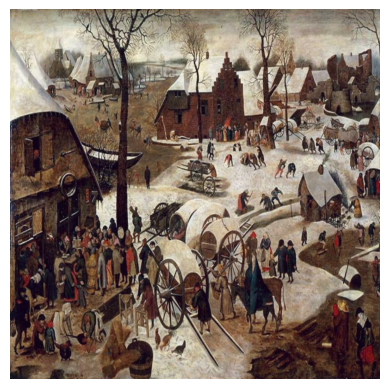

In [6]:
import matplotlib.pyplot as plt
tensor = image_t  

# Step 1: Move tensor to CPU and convert to numpy
if tensor.is_cuda:
    tensor = tensor.cpu()
image = tensor.numpy()

# Step 2: Normalize to [0, 1] if needed
if image.min() < 0 or image.max() > 1:
    image = (image - image.min()) / (image.max() - image.min())

# Step 3: Transpose to (H, W, C) for matplotlib
image = image.transpose(1, 2, 0)  # From (C, H, W) to (H, W, C)

# Step 4: Display
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()

In [7]:
output_directory = 'paintings_saliency_cat'
os.makedirs(output_directory, exist_ok=True)
for images,image_names, orig_sizes in test_dataloader:
    images= images.to(device)
    with torch.no_grad():
        predicted_saliency = model.forward(images)
        save_model_outputs_as_png(predicted_saliency, output_directory, image_names, orig_sizes)
print('Finished')

before torch.Size([1, 1, 768, 768])
after torch.Size([1, 768, 768])
[tensor([1170]), tensor([917])]
before torch.Size([1, 1, 768, 768])
after torch.Size([1, 768, 768])
[tensor([3911]), tensor([3071])]
before torch.Size([1, 1, 768, 768])
after torch.Size([1, 768, 768])
[tensor([1200]), tensor([883])]
before torch.Size([1, 1, 768, 768])
after torch.Size([1, 768, 768])
[tensor([898]), tensor([1200])]
before torch.Size([1, 1, 768, 768])
after torch.Size([1, 768, 768])
[tensor([890]), tensor([1200])]
before torch.Size([1, 1, 768, 768])
after torch.Size([1, 768, 768])
[tensor([1200]), tensor([897])]
before torch.Size([1, 1, 768, 768])
after torch.Size([1, 768, 768])
[tensor([1170]), tensor([1456])]
before torch.Size([1, 1, 768, 768])
after torch.Size([1, 768, 768])
[tensor([1170]), tensor([1479])]
before torch.Size([1, 1, 768, 768])
after torch.Size([1, 768, 768])
[tensor([1170]), tensor([784])]
before torch.Size([1, 1, 768, 768])
after torch.Size([1, 768, 768])
[tensor([772]), tensor([1200]

# Creating a deformed image

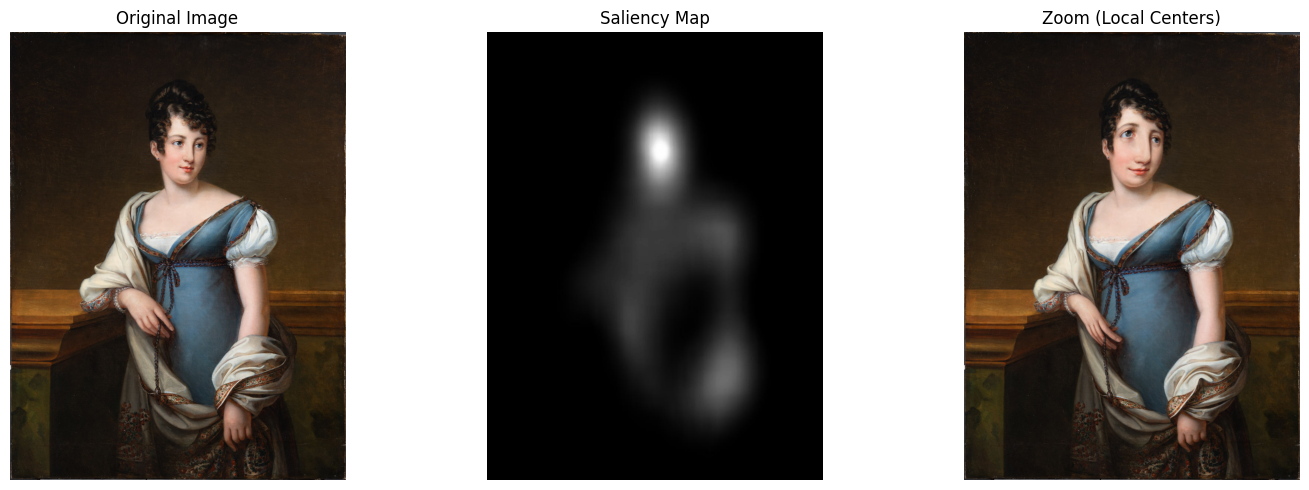

In [ ]:
import numpy as np
import cv2
from scipy.ndimage import gaussian_filter, map_coordinates, maximum_filter
from scipy.interpolate import griddata
import matplotlib.pyplot as plt

class SaliencyDeformer:
    def __init__(self, image, saliency_map):
        """
        Initialize the deformer with an image and its saliency map.
        
        Args:
            image: RGB image (H, W, 3) with values in [0, 255] or [0, 1]
            saliency_map: Grayscale saliency map (H, W) with values in [0, 1]
        """
        # Normalize image to [0, 1] if needed
        if image.max() > 1:
            self.image = image.astype(np.float32) / 255.0
        else:
            self.image = image.astype(np.float32)
            
        # Ensure saliency map is in [0, 1]
        self.saliency = np.clip(saliency_map.astype(np.float32), 0, 1)
        
        # Resize saliency map to match image if needed
        if self.saliency.shape != self.image.shape[:2]:
            self.saliency = cv2.resize(self.saliency, 
                                    (self.image.shape[1], self.image.shape[0]),
                                    interpolation=cv2.INTER_LINEAR)
        
        self.height, self.width = self.image.shape[:2]
    
    def _interpolate_image(self, new_y, new_x):
        """
        Interpolate the image using the new coordinate mappings.
        """
        # Clamp coordinates to image bounds
        new_y = np.clip(new_y, 0, self.height - 1)
        new_x = np.clip(new_x, 0, self.width - 1)
        
        # Interpolate each channel
        if len(self.image.shape) == 3:
            deformed = np.zeros_like(self.image)
            for c in range(self.image.shape[2]):
                deformed[:, :, c] = map_coordinates(
                    self.image[:, :, c], 
                    [new_y, new_x], 
                    order=1, 
                    mode='reflect'
                )
        else:
            deformed = map_coordinates(
                self.image, 
                [new_y, new_x], 
                order=1, 
                mode='reflect'
            )
        
        return np.clip(deformed, 0, 1)
    
    def _find_local_saliency_centers(self, blur_sigma):
        """
        Find local centers of high saliency for each pixel.
        This creates a field where each pixel points to its nearest high-saliency center.
        """
        # Smooth the saliency map more to find main centers
        smoothed_saliency = gaussian_filter(self.saliency, sigma=blur_sigma)
        
        # Find local maxima in the saliency map
        local_maxima = maximum_filter(smoothed_saliency, size=int(blur_sigma * 2)) == smoothed_saliency
        local_maxima = local_maxima & (smoothed_saliency > 0.3)  # Only significant maxima
        
        # Get coordinates of local maxima
        max_coords = np.where(local_maxima)
        max_y = max_coords[0]
        max_x = max_coords[1]
        max_values = smoothed_saliency[max_y, max_x]
        
        if len(max_y) == 0:
            # Fallback to image center if no maxima found
            center_y = np.full((self.height, self.width), self.height // 2, dtype=np.float32)
            center_x = np.full((self.height, self.width), self.width // 2, dtype=np.float32)
            return center_y, center_x
        
        # Create coordinate grids
        y_grid, x_grid = np.mgrid[0:self.height, 0:self.width]
        
        # For each pixel, find the nearest high-saliency center weighted by saliency value
        center_y = np.zeros((self.height, self.width), dtype=np.float32)
        center_x = np.zeros((self.height, self.width), dtype=np.float32)
        
        for i in range(self.height):
            for j in range(self.width):
                # Calculate distance to all maxima
                distances = np.sqrt((max_y - i)**2 + (max_x - j)**2)
                
                # Weight by saliency value and inverse distance
                weights = max_values / (distances + 1e-6)
                weights = weights / np.sum(weights)
                
                # Weighted average of center positions
                center_y[i, j] = np.sum(weights * max_y)
                center_x[i, j] = np.sum(weights * max_x)
        
        return center_y, center_x
    
    def zoom_deformation(self, zoom_strength=0.5, blur_sigma=5, local_centers=True):
        """
        Apply zoom effect to salient regions - expands high-saliency areas.
        
        Args:
            zoom_strength: How strong the zoom effect is (0.1 to 2.0)
            blur_sigma: Gaussian blur for smoothing the deformation field
            local_centers: If True, zoom around local saliency centers; if False, use global center
        """
        # Create smooth zoom field based on saliency
        zoom_field = gaussian_filter(self.saliency, sigma=blur_sigma)
        zoom_field = zoom_field * zoom_strength + 1.0  # Base zoom of 1.0
        
        # Create coordinate grids
        y, x = np.mgrid[0:self.height, 0:self.width]
        
        if local_centers:
            # Find local centers of high saliency for each pixel
            center_y, center_x = self._find_local_saliency_centers(blur_sigma * 2)
        else:
            # Use global image center
            center_y = np.full_like(y, self.height // 2, dtype=np.float32)
            center_x = np.full_like(x, self.width // 2, dtype=np.float32)
        
        # Calculate displacement from relevant centers
        dy = y - center_y
        dx = x - center_x
        
        # Apply zoom deformation
        new_y = center_y + dy / zoom_field
        new_x = center_x + dx / zoom_field
        
        # Interpolate the deformed image
        deformed = self._interpolate_image(new_y, new_x)
        return deformed
    
    


def demonstrate_effects(img_path, sal_path):

    # Load your image and saliency map
    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    saliency = cv2.imread(sal_path, cv2.IMREAD_GRAYSCALE) / 255.0

    # Create deformer and apply effects
    deformer = SaliencyDeformer(image, saliency)
    
    # Apply different deformation effects
    zoom_result = deformer.zoom_deformation(zoom_strength=0.8, local_centers=True)

    # Display results
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    axes[0].imshow(image)
    axes[0].set_title('Original Image')
    axes[0].axis('off')
    
    axes[1].imshow(saliency, cmap='gray')
    axes[1].set_title('Saliency Map')
    axes[1].axis('off')
    
    axes[2].imshow(zoom_result)
    axes[2].set_title('Zoom (Local Centers)')
    axes[2].axis('off')
    verlay_saliency_on_image
    plt.tight_layout()
    plt.show()



img_name = 'VOUET Simon, Jeune homme à la figue Inv.182.jpg'
img_name = 'PRINET R.X, Au balcon de Venise Inv.35.jpg'
img_name = 'HENNEQUIN Autoportrait 75.3.1.jpg'
img_name = 'duvidal-de-montferrier-madame-de-montaran-2023-11-1.jpg'

img_path = f'paintings_all/{img_name}'
sal_path = f'paintings_saliency_salicon/{img_name}'

demonstrate_effects(img_path, sal_path)

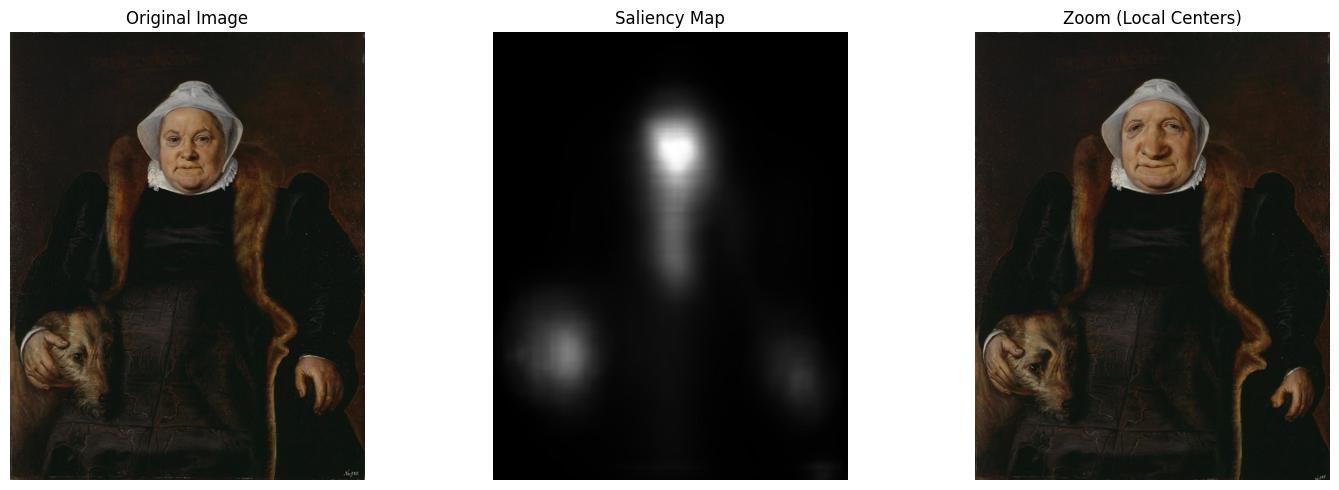

In [7]:
img_name = 'VOUET Simon, Jeune homme à la figue Inv.182.jpg'
img_name = 'PRINET R.X, Au balcon de Venise Inv.35.jpg'
img_name = 'HENNEQUIN Autoportrait 75.3.1.jpg'
img_name = 'duvidal-de-montferrier-madame-de-montaran-2023-11-1.jpg'
img_name  = 'FLORIS Frans, Portrait de dame âgée, parfois dit la Femme du fauconnier Inv.47.jpg'

img_path = f'paintings_all/{img_name}'
sal_path = f'paintings_saliency_cat/{img_name}'

demonstrate_effects(img_path, sal_path)

## Saving the images

In [ ]:
def save_array_as_image(array_to_save, image_name, output_directory):
    """
    Save a NumPy array as an image. Converts RGB to BGR if needed for OpenCV.

    Args:
        array_to_save (np.ndarray): Image array (grayscale or RGB/BGR).
        image_name (str): Filename (e.g. "output.jpg" or "map.png").
        output_directory (str): Directory to save the image.
    """
    os.makedirs(output_directory, exist_ok=True)
    output_path = os.path.join(output_directory, image_name)

    # Convert float [0, 1] to uint8 [0, 255]
    if array_to_save.dtype in [np.float32, np.float64]:
        array_to_save = np.clip(array_to_save, 0, 1) * 255
        array_to_save = array_to_save.astype(np.uint8)

    # Convert RGB to BGR if needed (e.g., if image looks blueish)
    if array_to_save.ndim == 3 and array_to_save.shape[2] == 3:
        # Heuristic: assume it's RGB and convert to BGR for OpenCV
        array_to_save = cv2.cvtColor(array_to_save, cv2.COLOR_RGB2BGR)

    # Handle grayscale images with shape (H, W, 1)
    if array_to_save.ndim == 3 and array_to_save.shape[2] == 1:
        array_to_save = array_to_save[:, :, 0]

    cv2.imwrite(output_path, array_to_save)
    print(f"Image saved to: {output_path}")



Image saved to: paintings_deformed_salicon/FLORIS Frans, Portrait de dame âgée, parfois dit la Femme du fauconnier Inv.47.jpg


In [38]:
import os
paintings_folder = 'paintings_all'
salmap_salicon_folder = 'paintings_saliency_salicon'
output_directory = 'paintings_deformed_salicon'

for img in os.listdir(salmap_salicon_folder):
    if img.endswith('.jpg'):

        img_path = os.path.join(paintings_folder, img)
        sal_path = os.path.join(salmap_salicon_folder, img)

        # Load your image and saliency map
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        saliency = cv2.imread(sal_path, cv2.IMREAD_GRAYSCALE) / 255.0

        # Create deformer and apply effects
        deformer = SaliencyDeformer(image, saliency)
        zoom_result = deformer.zoom_deformation(zoom_strength=0.8, local_centers=True)
        # Save the deformed image
        save_array_as_image(zoom_result, img, output_directory)

Image saved to: paintings_deformed_salicon/FLORIS Frans, Portrait de dame âgée, parfois dit la Femme du fauconnier Inv.47.jpg
Image saved to: paintings_deformed_salicon/HENNEQUIN Autoportrait 75.3.1.jpg
Image saved to: paintings_deformed_salicon/LEBASQUE Nu couché dans un paysage 81.16.4.jpg
Image saved to: paintings_deformed_salicon/BRUEGHEL LE JEUNE Pierre, Le paiement de la dîme, Inv 22 .jpg
Image saved to: paintings_deformed_salicon/Survage, Vision surréaliste Inv.81.16.10.jpg
Image saved to: paintings_deformed_salicon/duvidal-de-montferrier-madame-de-montaran-2023-11-1.jpg
Image saved to: paintings_deformed_salicon/PRINET R.X, Au balcon de Venise Inv.35.jpg
Image saved to: paintings_deformed_salicon/CRESPI Un marché 79.2.1.jpg
Image saved to: paintings_deformed_salicon/MANFREDI Bartoloméo, Soldats jouant aux cartes Inv.61.jpg
Image saved to: paintings_deformed_salicon/VOUET Simon, Jeune homme à la figue Inv.182.jpg
Image saved to: paintings_deformed_salicon/DENIS Au balcon de Veni

In [45]:
import cv2
import numpy as np
import os

def overlay_saliency_on_image(image_path, saliency_path, output_path, alpha=0.5):
    """
    Overlays a saliency map on top of an image and saves the result.

    Args:
        image_path (str): Path to the original image.
        saliency_path (str): Path to the grayscale saliency map.
        output_path (str): Path to save the overlay result.
        alpha (float): Transparency of the saliency heatmap (0–1).
    """
    # Load original image
    os.makedirs(output_path.split('/')[0], exist_ok=True)

    image = cv2.imread(image_path)
    if image is None:
        raise FileNotFoundError(f"Image not found: {image_path}")

    # Load saliency map and normalize
    saliency = cv2.imread(saliency_path, cv2.IMREAD_GRAYSCALE)
    if saliency is None:
        raise FileNotFoundError(f"Saliency map not found: {saliency_path}")
    saliency = cv2.resize(saliency, (image.shape[1], image.shape[0]))
    saliency_norm = cv2.normalize(saliency, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)

    # Apply color map (heatmap)
    heatmap = cv2.applyColorMap(saliency_norm, cv2.COLORMAP_JET)

    # Overlay: blend heatmap with image
    overlay = cv2.addWeighted(heatmap, alpha, image, 1 - alpha, 0)

    # Save result
    cv2.imwrite(output_path, overlay)
    print(f"Overlay saved to: {output_path}")


paintings_folder = 'paintings_all'
salmap_salicon_folder = 'paintings_saliency_cat'
output_folder = 'paitings_superimposed_cat'

for img in os.listdir(salmap_salicon_folder):
    if img.endswith('.jpg'):

        img_path = os.path.join(paintings_folder, img)
        sal_path = os.path.join(salmap_salicon_folder, img)
        output_path = os.path.join(output_folder, img)

        overlay_saliency_on_image(
            image_path=img_path,
            saliency_path=sal_path,
            output_path=output_path,
            alpha=0.5
        )



Overlay saved to: paitings_superimposed_cat/MANFREDI Bartoloméo, Soldats jouant aux cartes Inv.61.jpg
Overlay saved to: paitings_superimposed_cat/Survage, Vision surréaliste Inv.81.16.10.jpg
Overlay saved to: paitings_superimposed_cat/CRESPI Un marché 79.2.1.jpg
Overlay saved to: paitings_superimposed_cat/duvidal-de-montferrier-madame-de-montaran-2023-11-1.jpg
Overlay saved to: paitings_superimposed_cat/HENNEQUIN Autoportrait 75.3.1.jpg
Overlay saved to: paitings_superimposed_cat/LEBASQUE Nu couché dans un paysage 81.16.4.jpg
Overlay saved to: paitings_superimposed_cat/VOUET Simon, Jeune homme à la figue Inv.182.jpg
Overlay saved to: paitings_superimposed_cat/FLORIS Frans, Portrait de dame âgée, parfois dit la Femme du fauconnier Inv.47.jpg
Overlay saved to: paitings_superimposed_cat/BRUEGHEL LE JEUNE Pierre, Le paiement de la dîme, Inv 22 .jpg
Overlay saved to: paitings_superimposed_cat/DENIS Au balcon de Venise D.75.1.13.jpg
Overlay saved to: paitings_superimposed_cat/PRINET R.X, Au 